In [1]:
import pathlib
import os
import tqdm
import argparse
import math
from ast import literal_eval

import yaml
import numpy as np
import matplotlib.pyplot as plt
import torch
import dataset
import timm
from sklearn.cluster import KMeans

In [10]:
dataset_path = "C:\\Users\s2231\PycharmProjects\FastFlow\Fast_flow\FastFlow\data\package_only"
config_path = "C:\\Users\s2231\PycharmProjects\FastFlow\Fast_flow\FastFlow\configs\wide_resnet50_2.yaml"

parser = argparse.ArgumentParser()
parser.add_argument(
    "-cfg", "--config", type=str, required=True, help="path to config file"
)
parser.add_argument('--name', type=str, required=True, help='dataset name')
parser.add_argument("--data", type=str, required=True, help="path to dataset folder")
parser.add_argument("-cat", "--category", type=str, required=True)
parser.add_argument('--valid', type=str, help='validation category')
parser.add_argument('--color', type=str, choices=['rgb', 'gray'])
parser.add_argument('-p', '--patchsize', type=int, help='patch size. By default, patch separation will not do')
parser.add_argument('--random', action='store_true', help='random patch sampling')
parser.add_argument('--mask', action='store_true', help='target mask')

args = parser.parse_args(['--config', config_path, '--name', 'package', '--data', dataset_path, '-cat', 'cut', '--valid', 'cut'])

In [11]:
# data loaderの作成
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

train_dataloader = dataset.build_train_data_loader(args=args, config=config)

In [12]:
# load model
resnet50 = timm.create_model(
    model_name=config['backbone_name'],
    pretrained=True,
    features_only=True,
    out_indices=[4]
)
resnet50.eval()
channels = resnet50.feature_info.channels()
scale = resnet50.feature_info.reduction()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/wide_resnet50_racm-8234f177.pth" to C:\Users\s2231/.cache\torch\hub\checkpoints\wide_resnet50_racm-8234f177.pth

KeyboardInterrupt



In [10]:
input_size = [math.ceil(240/scale[0]), math.ceil(320/scale[0])]
input_size

[8, 10]

In [11]:
gap = torch.nn.AvgPool2d(kernel_size=input_size, stride=input_size)

In [12]:
feature_list = []
for data in tqdm.tqdm(train_dataloader):
    outputs = resnet50(data)[0]
    outputs = gap(outputs)[..., 0, 0]
    feature_list.append(outputs)

  4%|▍         | 6/141 [00:08<03:11,  1.42s/it]


RuntimeError: [enforce fail at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10\core\impl\alloc_cpu.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 9830400 bytes.

k-meansのサンプル

In [49]:
def gen(n=2, k=3):
    """1x1の正方形内の点をランダムにn個サンプリングし，適当にスライドするという手順を繰り返し，k個のクラスタPを作成
    Args:
        n: クラスタ内のサンプル数
        k: クラスタ数

    Returns:
        P: クラスタ, (n*k, 2), J次元空間内のベクトルを考える際は(n*k, J)となる．
    """
    P = np.random.random((n, 2)) + np.random.randint(0, 10, 2)
    for i in range(k - 1):
        pts = np.random.random((n, 2)) + np.random.randint(0, 10, 2)
        P = np.concatenate((P, pts))
    return P

(6, 2)

1.2403630009006354


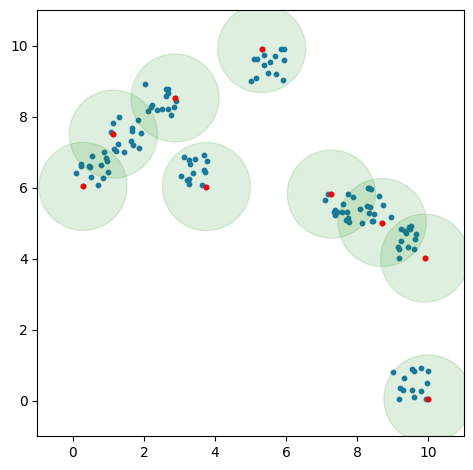

In [51]:
def greedy_2_approx(V, k):
    """greedy法にもとづき，中心点cを選ぶ．具体的には，まずランダムに点を一つ選びSに追加し，その後，S内の点から最も離れた点をSに追加するという手順を繰り返す．
    Args:
        V: クラスタリング対象のベクトル集合
        k: クラスタ数

    Returns:

    """

    # Vからランダムに1つの点を選択し，Sに追加する．
    S = [np.random.randint(len(V))]
    while len(S) < k:
        dists = []
        # V内の各点について，S内のすべての点との距離(L2ノルム)を評価し，その中の最小距離をdistsに格納(S内のどの点からも離れている点を選びたい)
        for i in range(len(V)):
            dists.append(min(np.linalg.norm(V[i] - V[s]) for s in S))

        # 最小距離が最も大きい点(S内のどの点からも離れている点)のindexをSに追加
        S.append(np.argmax(dists))
    return S


def radius(V, S):
    return max(min(np.linalg.norm(V[i] - V[s]) for s in S) for i in range(len(V)))


def draw_circle(V, S, r):
    for s in S:
        c = plt.Circle(V[s], r, alpha=0.125, color='g', edgecolor=None)
        plt.gca().add_artist(c)
    plt.gca().scatter(V[S, 0], V[S, 1], color='r', s=10)
    print(r)


def draw(V, S):
    plt.gca().scatter(V[:, 0], V[:, 1], s=10)
    draw_circle(V, S, radius(V, S))

    plt.gca().set_aspect('equal')
    plt.tight_layout()
    plt.gca().set_xlim([-1, 11])
    plt.gca().set_ylim([-1, 11])

n, k = 15, 9
V = gen(n, k * 1)
S = greedy_2_approx(V, k)
draw(V, S)
plt.savefig('kcen.png', bbox_inches='tight')
plt.show()